In [ ]:
!pip install imblearn==0.0

     |████████████████████████████████| 206 kB 13.4 MB/s 


In [ ]:
# Start writing code here...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

In [ ]:
def calculate_age(birthDate):
    #birthDate=str(birthDate)
    d,m,y = birthDate.split('-')
    if int(y) < 21: y='20'+y
    else: y= '19'+y
    b = date(int(y),int(m),int(d))
    today=date.today()
    return today.year - b.year - ((today.month, today.day) <(b.month, b.day))

def yrs_mon_to_month(s):
    sp=re.split('yrs|mon',s)
    return int(sp[0])*12 + int(sp[1])

def encode_description(X):
    '''

    '''
    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('No Bureau History Available', 
                                     'Not Scored: Sufficient History Not Available','Not Scored: Not Enough Info available on the customer',
                                     'Not Scored: No Activity seen on the customer (Inactive)', 
                                     'Not Scored: No Updates available in last 36 months', 'Not Scored: Only a Guarantor'),(0, 0, 0, 0, 0, 0))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('L-Very High Risk', 'M-Very High Risk', 
                                     'Not Scored: More than 50 active Accounts found'), (1, 1, 1))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('J-High Risk', 'K-High Risk'), (2, 2))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('H-Medium Risk', 'I-Medium Risk'), (3, 3))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('E-Low Risk', 'F-Low Risk', 'G-Low Risk'), (4, 4, 4))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('A-Very Low Risk', 'B-Very Low Risk',
                                      'C-Very Low Risk', 'D-Very Low Risk'), (5, 5, 5, 5))
    X=X.drop(['PERFORM_CNS.SCORE'], axis=1) # drop PERFORM_CNS.SCORE
    return X

def get_balance(df):
    # down sampling negative instances(nondefault), keep all the positive instances
    nondefault=df[df.loan_default==0].sample(n=df.loan_default.value_counts()[1], random_state=0)
    default=df[df.loan_default==1]
    df_balance= default.append(nondefault, ignore_index=True)
    df_balance=df_balance.sample(n=len(df_balance))
    return df_balance

In [ ]:
def preprocess(df):
    # transform birthDate to age
    df['Date.of.Birth']=df['Date.of.Birth'].apply(lambda x: calculate_age(x))
    df=df.rename(columns={'Date.of.Birth': 'Age'})

    # one hot encoding Employment.Type
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df=pd.DataFrame(enc.fit_transform(df[['Employment.Type']]).toarray())
    df=df.join(enc_df)
    df.columns = df.columns.astype(str) 
    df=df.rename(columns={'0': 'Salaried',
                       '1': 'Self_employed',
                       '2': 'Unknown_employ'})
    df=df.drop('Employment.Type',axis=1)

    # 
    df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(lambda s: yrs_mon_to_month(s))
    df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(lambda s: yrs_mon_to_month(s))

    # transform DisbursalDate to month
    df['DisbursalDate']=pd.to_datetime(df['DisbursalDate'],errors='coerce',dayfirst=True).dt.month
    df=df.rename(columns={'DisbursalDate': 'DisbursalMonth'})

    # encoding DisbursalMonth
    df=pd.get_dummies(df, columns=["DisbursalMonth"], prefix=["DisbursalMonth"])
    df['DisbursalMonth_8'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_9'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_10'] = df['DisbursalMonth_8'].astype(int)

    # encoding description
    df=encode_description(df)

    # drop some columns with ID (will try encoding later)
    id_col_to_drop=['UniqueID','branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID']
    df=df.drop(columns=id_col_to_drop)

    # merge asset_cost and disbursed_amount
    df['Downpayment']=df['asset_cost']-df['disbursed_amount']
    df=df.drop(['asset_cost','disbursed_amount'],axis=1)

    drop_max=['PRI.NO.OF.ACCTS','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
    for d in drop_max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    drop_2max=['Downpayment','SEC.INSTAL.AMT']
    for d in drop_2max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    # 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE' has negative values
    #print('Taking logrithmic')
    df['PRI.CURRENT.BALANCE']=df['PRI.CURRENT.BALANCE']-np.min(df['PRI.CURRENT.BALANCE'])
    df['SEC.CURRENT.BALANCE']=df['SEC.CURRENT.BALANCE']-np.min(df['SEC.CURRENT.BALANCE'])

    # # without 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE'
    # to_log_cols=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
    #    'PRI.OVERDUE.ACCTS' , 'PRI.SANCTIONED.AMOUNT',
    #    'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
    #    'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT',
    #    'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
    #    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
    #    'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment']
    to_log_cols=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS' , 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment','PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE']
    for c in to_log_cols:
        df[c]=np.log1p(df[c])
    #print('logarithmic completed')
    # # 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE' has negative values
    # df['PRI.CURRENT.BALANCE']=df['PRI.CURRENT.BALANCE'].apply(lambda x: np.log1p(x) if x>=0 else -np.log1p(np.abs(x)))
    # df['SEC.CURRENT.BALANCE']=df['SEC.CURRENT.BALANCE'].apply(lambda x: np.log1p(x) if x>=0 else -np.log1p(np.abs(x)))

    # down sample
    #df=get_balance(df)
    
    return df

In [ ]:
train_raw=pd.read_csv('train_LTFS.csv')
train=train_raw.copy(deep=True)
test_raw=pd.read_csv('test_LTFS.csv')

In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

In [ ]:
train=preprocess(train)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233146 entries, 0 to 233153
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ltv                                  233146 non-null  float64
 1   Age                                  233146 non-null  int64  
 2   MobileNo_Avl_Flag                    233146 non-null  int64  
 3   Aadhar_flag                          233146 non-null  int64  
 4   PAN_flag                             233146 non-null  int64  
 5   VoterID_flag                         233146 non-null  int64  
 6   Driving_flag                         233146 non-null  int64  
 7   Passport_flag                        233146 non-null  int64  
 8   PERFORM_CNS.SCORE.DESCRIPTION        233146 non-null  int64  
 9   PRI.NO.OF.ACCTS                      233146 non-null  float64
 10  PRI.ACTIVE.ACCTS                     233146 non-null  float64
 11  PRI.OVERDUE.A

In [ ]:
train.describe()

,ltv,Age,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,...,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Salaried,Self_employed,Unknown_employ,DisbursalMonth_8,DisbursalMonth_9,DisbursalMonth_10,Downpayment
count,233146.000000,233146.000000,233146.0,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,...,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000,233146.000000
mean,4.313817,36.658309,1.0,0.840319,0.075571,0.144948,0.023239,0.002127,1.707046,0.728021,...,1.529728,0.115933,0.217070,0.419720,0.547425,0.032855,0.291658,0.291658,0.291658,9.843959
std,0.173160,9.824017,0.0,0.366311,0.264311,0.352049,0.150661,0.046075,2.123325,0.892370,...,1.695682,0.317669,0.412252,0.493514,0.497747,0.178257,0.454527,0.454527,0.454527,0.498859
min,2.400619,20.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.293550
25%,4.246779,29.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.479375
50%,4.354141,35.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.797432
75%,4.438761,44.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.386294,...,3.218876,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.188930
max,4.564348,71.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.872118,...,6.150603,3.610918,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.106777


In [ ]:
train

,ltv,Age,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,...,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Salaried,Self_employed,Unknown_employ,DisbursalMonth_8,DisbursalMonth_9,DisbursalMonth_10,Downpayment
0,4.505902,37,1,1,0,0,0,0,0,0.000000,...,0.000000,0.000000,0,1.0,0.0,0.0,1,1,1,8.964823
1,4.307168,35,1,1,0,0,0,0,3,0.693147,...,3.178054,0.000000,1,0.0,1.0,0.0,0,0,0,9.820432
2,4.506785,35,1,1,0,0,0,0,0,0.000000,...,0.000000,0.000000,0,0.0,1.0,0.0,1,1,1,8.997518
3,4.494015,27,1,1,0,0,0,0,1,1.386294,...,2.772589,0.693147,1,0.0,1.0,0.0,0,0,0,9.059634
4,4.493009,43,1,1,0,0,0,0,0,0.000000,...,0.000000,0.693147,1,0.0,1.0,0.0,0,0,0,8.977525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,4.122608,32,1,0,0,1,0,0,5,1.609438,...,3.688879,0.000000,0,1.0,0.0,0.0,0,0,0,10.650010
233150,4.330075,32,1,0,0,1,0,0,5,0.693147,...,1.945910,0.000000,0,0.0,1.0,0.0,0,0,0,10.201739
233151,3.900962,44,1,1,0,0,0,0,0,0.000000,...,0.000000,0.000000,0,1.0,0.0,0.0,0,0,0,10.538184
233152,3.914021,27,1,1,0,0,0,0,0,0.000000,...,0.000000,0.000000,0,1.0,0.0,0.0,0,0,0,10.572035


In [ ]:
# X = train.drop('loan_default',1) 
# y = train.loan_default
# X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)
# def fit_LR(data):
#     lr=LogisticRegression(class_weight='balanced')
#     #return np.mean(cross_val_score(lr, data, y_train, cv=3,scoring="f1_weighted"))
#     return np.mean(cross_val_score(lr, data, y_train, cv=3))

In [ ]:

#  mi_cols=['AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS',
#        'CREDIT.HISTORY.LENGTH', 'Salaried', 'Aadhar_flag',
#        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Self_employed',
#        'PRI.NO.OF.ACCTS', 'Downpayment', 'PRI.OVERDUE.ACCTS', 'VoterID_flag',
#        'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE.DESCRIPTION', 'ltv'] # first round pick according to the full model
# # mi_cols=['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
# #        'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
# #        'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
# #        'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
# #        'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
# #        'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
# #        'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
# #        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
# #        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
# #        'loan_default', 'Salaried', 'Self_employed', 'Unknown_employ',
# #        'DisbursalMonth_8', 'DisbursalMonth_9', 'DisbursalMonth_10',
# #        'Downpayment']
# mi_cols=np.array(mi_cols)
# cor_cols=['AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS',
#        'CREDIT.HISTORY.LENGTH', 'Salaried', 'Aadhar_flag',
#        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Self_employed',
#        'PRI.NO.OF.ACCTS', 'Downpayment', 'PRI.OVERDUE.ACCTS', 'VoterID_flag',
#        'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE.DESCRIPTION', 'ltv']

# selected=[]
# global_select=[]
# global_acc=0.0
# last_acc=0.0#fit(train[selected].to_numpy())
# best_acc=0.0
# best_col=""
# total=count=len(cor_cols)
# miss=0
# while((count>0)):
#     for i in range(len(cor_cols)):
#         current=cor_cols[i]
#         if(current in selected):
#             continue
#         cols=np.append(selected,current)
#         data=X_train[cols].to_numpy() #####
#         acc=fit_LR(data)
#         if(acc>best_acc):
#             best_acc=acc
#             best_col=current
#     if(best_acc>last_acc):
#         last_acc=best_acc
#         global_acc=best_acc
#         selected=np.append(selected,best_col)
#         f=np.where(mi_cols==current)
#         if(f[0].size>0):
#             mi_cols=np.delete(mi_cols,f[0][0])
#         miss=0
#         global_select=selected
#         print("iter:"+str(total-count))
#         print("found:"+str(selected)+" "+str(last_acc))
#     else:
#         selected=np.append(selected,mi_cols[0])
#         mi_cols=np.delete(mi_cols,0)
#         data=X_train[selected].to_numpy()
#         acc=fit_LR(data)
#         print("iter:"+str(total-count))
#         print("miss:"+str(selected)+" "+str(acc))
#         last_acc=acc
#         best_acc=acc
#         if(acc>global_acc):
#             global_acc=acc
#             global_select=selected
#         miss+=1
#         print('miss',miss)
#     count-=1
        
#     if(miss> 10):
#         break

iter:0
found:['ltv'] 0.5495821739780515
iter:1
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION'] 0.564924043390433
iter:2
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION'
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] 0.5691017651719354
iter:3
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION'
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' 'Salaried'] 0.57164227513323
iter:4
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION'
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' 'Salaried' 'Downpayment'] 0.5744650371534936
iter:5
found:['ltv' 'PERFORM_CNS.SCORE.DESCRIPTION'
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' 'Salaried' 'Downpayment'
 'NO.OF_INQUIRIES'] 0.5766244836184032
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

In [ ]:
X = train.drop('loan_default',1) 
# X=train[['MobileNo_Avl_Flag',
#  'ltv',
#  'PERFORM_CNS.SCORE.DESCRIPTION',
#  'VoterID_flag',
#  'PRI.OVERDUE.ACCTS',
#  'NO.OF_INQUIRIES',
#  'PRI.NO.OF.ACCTS',
#  'Age',
#  'Self_employed',
#  'PRI.CURRENT.BALANCE',
#  'PRIMARY.INSTAL.AMT',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
#  'Downpayment',
#  'PRI.ACTIVE.ACCTS',
#  'PRI.DISBURSED.AMOUNT',
#  'SEC.CURRENT.BALANCE',
#  'AVERAGE.ACCT.AGE',
#  'CREDIT.HISTORY.LENGTH',
#  'PRI.SANCTIONED.AMOUNT',
#  'Aadhar_flag',
#  'Driving_flag',
#  'Passport_flag',
#  'PAN_flag']]
# X = train[['ltv','PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Salaried', 'Downpayment',
#  'NO.OF_INQUIRIES', 'VoterID_flag', 'PRI.OVERDUE.ACCTS', 'PRI.NO.OF.ACCTS',
#  'AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS',
#  'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS', 'CREDIT.HISTORY.LENGTH']]
y = train.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

In [ ]:
os = SMOTE(random_state=0) #   We are using SMOTE as the function for oversampling
os_data_train,os_data_test= os.fit_resample(X_train,y_train.ravel())
# os_data_train = pd.DataFrame(data=os_data_train,columns = [col for col in X_train.columns])
# os_data_test= pd.DataFrame(data=os_data_test,columns=["loan_default"])

In [ ]:
lr=LogisticRegression(class_weight='balanced').fit(os_data_train,os_data_test)
y_vali_pred=lr.predict(X_vali)
confusion = metrics.confusion_matrix(y_vali, y_vali_pred)
print('----confusion matrix----')
print(confusion)
print('Accuracy_Score:', metrics.accuracy_score(y_vali, y_vali_pred))
# print('Sensitivity or Recall:', metrics.recall_score(y_vali, y_vali_pred))
print(classification_report(y_vali, y_vali_pred))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
----confusion matrix----
[[29346 25631]
 [ 5715  9252]]
Accuracy_Score: 0.5518414731785428
              precision    recall  f1-score   support

           0       0.84      0.53      0.65     54977
           1       0.27      0.62      0.37     14967

    accuracy                           0.55     69944
   macro avg       0.55      0.58      0.51     69944
weighted avg       0.71      0.55      0.59     69944



In [ ]:
lr=LogisticRegression(class_weight='balanced').fit(X_train,y_train)
y_vali_pred=lr.predict(X_vali)
confusion = metrics.confusion_matrix(y_vali, y_vali_pred)
print('----confusion matrix----')
print(confusion)
print('Accuracy_Score:', metrics.accuracy_score(y_vali, y_vali_pred))
# print('Sensitivity or Recall:', metrics.recall_score(y_vali, y_vali_pred))
print(classification_report(y_vali, y_vali_pred))


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
----confusion matrix----
[[29283 25694]
 [ 5493  9474]]
Accuracy_Score: 0.5541147203477067
              precision    recall  f1-score   support

           0       0.84      0.53      0.65     54977
           1       0.27      0.63      0.38     14967

    accuracy                           0.55     69944
   macro avg       0.56      0.58      0.52     69944
weighted avg       0.72      0.55      0.59     69944



In [ ]:
# get importance
importance = lr.coef_[0] # LR feature importance
# summarize feature importance
for i, v in enumerate(importance):
        print('Feature: {}, Score:{}'.format (i, v))

Feature: 0, Score:0.011107369388343613
Feature: 1, Score:1.1596181568684492
Feature: 2, Score:-0.03462352555779366
Feature: 3, Score:0.20405661554221646
Feature: 4, Score:0.6741743010687916
Feature: 5, Score:0.26543166433979276
Feature: 6, Score:-0.047355497938950095
Feature: 7, Score:-0.011039854731400376
Feature: 8, Score:0.1630643002321085
Feature: 9, Score:-0.26627653134218726
Feature: 10, Score:0.012570367827500921
Feature: 11, Score:0.4483772155589209
Feature: 12, Score:-0.0955747458731183
Feature: 13, Score:-0.24495020296986642
Feature: 14, Score:0.010286086839209502
Feature: 15, Score:0.039540761641486906
Feature: 16, Score:0.2156070219949304
Feature: 17, Score:-0.23673512822648354
Feature: 18, Score:0.0011051432469229069
Feature: 19, Score:-0.11967735083790917
Feature: 20, Score:-0.15404475456751232
Feature: 21, Score:-0.0658039993660597
Feature: 22, Score:-0.0587505935801105


Text(0, 0.5, 'Features')

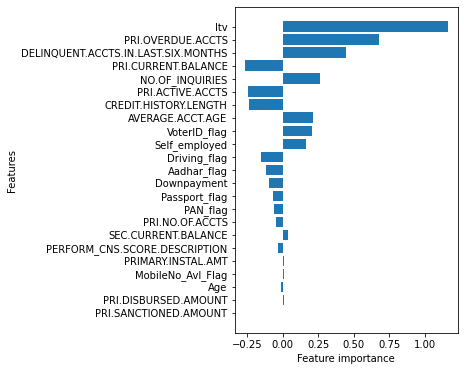

In [ ]:
sortLR= np.abs(importance).argsort()
plt.figure(figsize=(4,6))
plt.barh(X.columns[sortLR], importance[sortLR])
plt.xlabel('Feature importance')
plt.ylabel('Features')
#plt.savefig('LR_importance.png',dpi=150,bbox_inches='tight')

In [ ]:
X.columns[sortLR][-15:]

Index(['NEW.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'PRI.DISBURSED.AMOUNT', 'CREDIT.HISTORY.LENGTH', 'PRI.ACTIVE.ACCTS',
       'Aadhar_flag', 'Self_employed', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'VoterID_flag', 'PRI.NO.OF.ACCTS', 'PRI.OVERDUE.ACCTS', 'Downpayment',
       'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE.DESCRIPTION', 'ltv'],
      dtype='object')

In [ ]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5 MB 30.8 MB/s 
     |████████████████████████████████| 231 kB 81.4 MB/s 


In [ ]:
from sklearn.datasets import load_boston
import statsmodels.api as sm



X = train.drop('loan_default',1) 
y = train.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

In [ ]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [ ]:
X

,ltv,Age,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,...,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,Salaried,Self_employed,Unknown_employ,DisbursalMonth_8,DisbursalMonth_9,DisbursalMonth_10,Downpayment
80195,4.412677,51,1,1,0,0,0,0,738,5,...,2.397895,3.178054,0.693147,1.0,0.0,0.0,0,0,0,9.579487
96173,4.448633,58,1,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0,0,0,9.280799
4376,4.510090,32,1,1,0,0,0,0,300,1,...,2.639057,3.258097,1.098612,1.0,0.0,0.0,0,0,0,9.032768
9191,4.237723,42,1,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0,0,0,10.417029
18205,4.227709,21,1,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,1.0,0,0,0,10.114680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7536,4.330602,33,1,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0,0,0,9.890959
24320,4.388506,36,1,1,0,0,0,0,763,5,...,2.708050,3.367296,0.000000,1.0,0.0,0.0,0,0,0,9.831938
32458,4.505239,33,1,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.0,0.0,0.0,1,1,1,9.197458
42614,4.437816,40,1,1,0,0,0,0,300,1,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0,0,0,9.490015


In [ ]:
result= forward_regression(X_train, y_train, 0.2, True)

#print('resulting features:')
print(result)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
Add  MobileNo_Avl_Flag              with p-value 0.0
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
Add  ltv                            with p-value 1.99427e-222
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
Add  PERFORM_CNS.SCORE.DESCRIPTION  with p-value

In [ ]:
result

['MobileNo_Avl_Flag',
 'ltv',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'VoterID_flag',
 'PRI.OVERDUE.ACCTS',
 'NO.OF_INQUIRIES',
 'PRI.NO.OF.ACCTS',
 'Age',
 'Self_employed',
 'PRI.CURRENT.BALANCE',
 'PRIMARY.INSTAL.AMT',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'Downpayment',
 'PRI.ACTIVE.ACCTS',
 'PRI.DISBURSED.AMOUNT',
 'SEC.CURRENT.BALANCE',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'PRI.SANCTIONED.AMOUNT',
 'Aadhar_flag',
 'Driving_flag',
 'Passport_flag',
 'PAN_flag']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85463a1c-f246-4a97-953d-d1ccc73b61e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>